In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u

import gala.coordinates as gc

import pickle

coord.galactocentric_frame_defaults.set('v4.0');

In [2]:
plt.style.use('notebook')

In [3]:
# distance modulus
distance_app = 8.5*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

iso_full = Table.read('/home/ana/data/isochrones/gaia/mist_13.0_-2.00.cmd',
                 format='ascii.commented_header', header_start=12)
# phasecut = (iso_full['phase']>=0) & (iso_full['phase']<4)
# iso = iso_full[phasecut]
# i_bprp_ = iso['Gaia_BP_EDR3']-iso['Gaia_RP_EDR3']
# i_g_ = iso['Gaia_G_EDR3']+dm

phasecut = (iso_full['phase']>=0) & (iso_full['phase']<4)
iso = iso_full[phasecut]

# main sequence + rgb
i_bprp = iso['Gaia_BP_EDR3']-iso['Gaia_RP_EDR3']
i_g = iso['Gaia_G_EDR3']+dm

In [4]:
t = Table(fits.getdata('../data/gd1_retro.fits.gz'))

In [5]:
points = np.array([t['bp_rp0'], t['g0']]).T

In [6]:
dist = 8.*u.kpc
arr_dist = np.ones(len(t))*dist

ceq_nc = coord.SkyCoord(ra=t['ra']*u.deg, dec=t['dec']*u.deg, distance=arr_dist,
                  pm_ra_cosdec=t['pmra']*u.mas/u.yr, pm_dec=t['pmdec']*u.mas/u.yr,
                  radial_velocity=np.zeros(len(t))*u.km/u.s, frame='icrs')
ceq = gc.reflex_correct(ceq_nc)
c_gal = ceq.transform_to(coord.Galactic)

c = ceq.transform_to(gc.GD1)

In [7]:
ind_phi2 = (c.phi2<0.5*u.deg) & (c.phi2>-0.5*u.deg) & (c.phi1<0*u.deg)
ind_off = (np.abs(c.phi2)>2*u.deg) & (np.abs(c.phi2)<2.5*u.deg) & (c.phi1<0*u.deg)
ind_pm = ((c.pm_phi1_cosphi2>-8.2*u.mas/u.yr) & (c.pm_phi1_cosphi2<-4.2*u.mas/u.yr) & (c.pm_phi2>-1*u.mas/u.yr)
          & (c.pm_phi2<1*u.mas/u.yr))

In [8]:
i_left = i_bprp - 0.2*(i_g/28)**2
i_right = i_bprp + 0.3*(i_g/28)**2

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<20.5) & (poly[:,1]>17.4)
poly_main = poly[ind]

path_main = mpl.path.Path(poly_main)
ind_cmd = path_main.contains_points(points)

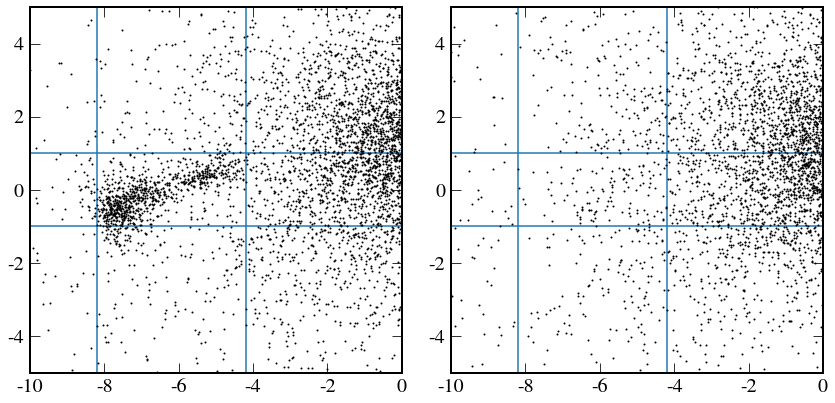

In [9]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

for e in range(2):
    plt.sca(ax[e])
    plt.axvline(-8.2)
    plt.axvline(-4.2)
    plt.axhline(-1)
    plt.axhline(1)

    plt.ylim(-5,5)
    plt.xlim(-10,0)

plt.sca(ax[0])
plt.plot(c.pm_phi1_cosphi2[ind_phi2 & ind_cmd], c.pm_phi2[ind_phi2 & ind_cmd], 'ko', ms=2, mew=0)

plt.sca(ax[1])
plt.plot(c.pm_phi1_cosphi2[ind_off & ind_cmd], c.pm_phi2[ind_off & ind_cmd], 'ko', ms=2, mew=0)
    
plt.tight_layout()

In [10]:
g_min = 14.7
g_max = 15.7
bprp_min = -0.1
bprp_max = 0.4
poly_bhb = np.array([[bprp_min, g_max], [bprp_min, g_min], [bprp_max, g_min], [bprp_max, g_max]])
path_bhb = mpl.path.Path(poly_bhb)
ind_bhb = path_bhb.contains_points(points)

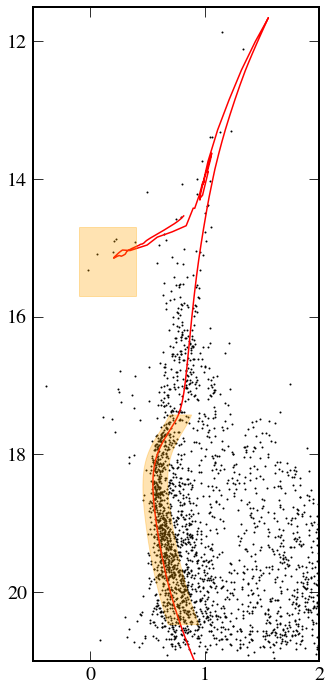

In [11]:
plt.figure(figsize=(5,10))
plt.plot(t['bp_rp0'][ind_phi2 & ind_pm], t['g0'][ind_phi2 & ind_pm], 'ko', ms=2, mew=0, alpha=1)
plt.plot(i_bprp, i_g, 'r-')

pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

pm = mpl.patches.Polygon(poly_bhb, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

# plt.gca().invert_yaxis()
plt.xlim(-0.5, 2)
plt.ylim(21, 11.5)
plt.tight_layout()

In [12]:
pbhb = np.load('/home/ana/projects/disrupted_gc/data/bhb_mg.npy')
mg_bhb = np.poly1d(pbhb)

ind_mem_bhb = ind_pm & ind_bhb & ind_phi2
ind_mem_bhb = ind_pm & ind_bhb & (np.abs(c.phi2)<3*u.deg)

mu = t['g0'][ind_mem_bhb] - mg_bhb(t['bp_rp0'][ind_mem_bhb])
d = (10**(0.2*mu + 1)*u.pc).to(u.kpc)

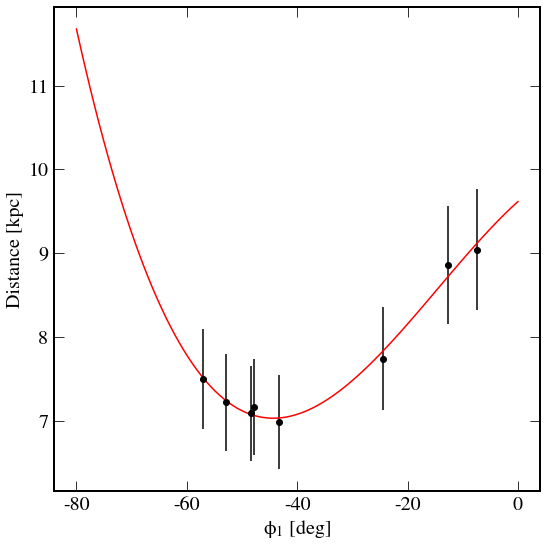

In [13]:
# plt.errorbar(ceq_nc.ra.wrap_at(wangle)[ind_mem_bhb].value, d.value, yerr=0.08*d.value, fmt='o', color='k')
plt.errorbar(c.phi1[ind_mem_bhb].value, d.value, yerr=0.08*d.value, fmt='o', color='k')

kdist = 3
pdist = np.polyfit(c.phi1[ind_mem_bhb].value, d.value, kdist)
poly_dist = np.poly1d(pdist)
np.save('../data/gd1_phi1_dist', pdist)

phi1_ = np.linspace(-80,0,100)
dist_ = poly_dist(phi1_)
plt.plot(phi1_, dist_, 'r-')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('Distance [kpc]')
plt.tight_layout()

## Distance gradient

In [14]:
arr_dist = poly_dist(c.phi1.value)*u.kpc
ceq_nc = coord.SkyCoord(ra=t['ra']*u.deg, dec=t['dec']*u.deg, distance=arr_dist,
                  pm_ra_cosdec=t['pmra']*u.mas/u.yr, pm_dec=t['pmdec']*u.mas/u.yr,
                  radial_velocity=np.zeros(len(t))*u.km/u.s, frame='icrs')
c_nc = ceq_nc.transform_to(gc.GD1)

ceq = gc.reflex_correct(ceq_nc)
c_gal = ceq.transform_to(coord.Galactic)
c = ceq.transform_to(gc.GD1)

In [15]:
points_pm = np.array([c.pm_phi1_cosphi2, c.pm_phi2]).T

In [16]:
ind_phi2 = (c.phi2<0.5*u.deg) & (c.phi2>-0.5*u.deg) & (c.phi1<0*u.deg)
ind_off = (np.abs(c.phi2)>2*u.deg) & (np.abs(c.phi2)<2.5*u.deg) & (c.phi1<0*u.deg)
ind_pm = ((c.pm_phi1_cosphi2>-8.2*u.mas/u.yr) & (c.pm_phi1_cosphi2<-4.2*u.mas/u.yr) & (c.pm_phi2>-1*u.mas/u.yr)
          & (c.pm_phi2<1*u.mas/u.yr))

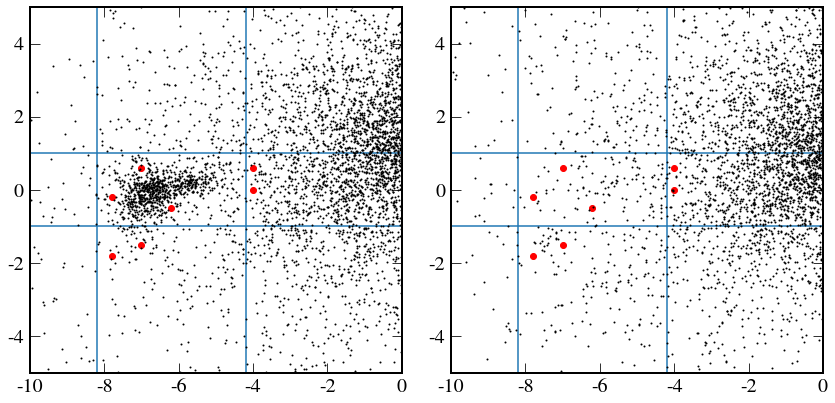

In [17]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

poly_pm = np.array([[-4, 0.6], [-7,0.6], [-7.8, -0.2], [-7.8, -1.8], [-7,-1.5], [-6.2,-0.5], [-4,0]])
path_pm = mpl.path.Path(poly_pm)

for e in range(2):
    plt.sca(ax[e])
    plt.axvline(-8.2)
    plt.axvline(-4.2)
    plt.axhline(-1)
    plt.axhline(1)
    plt.plot(poly_pm[:,0], poly_pm[:,1], 'ro')

    plt.ylim(-5,5)
    plt.xlim(-10,0)

plt.sca(ax[0])
plt.plot(c.pm_phi1_cosphi2[ind_phi2 & ind_cmd], c.pm_phi2[ind_phi2 & ind_cmd], 'ko', ms=2, mew=0)

plt.sca(ax[1])
plt.plot(c.pm_phi1_cosphi2[ind_off & ind_cmd], c.pm_phi2[ind_off & ind_cmd], 'ko', ms=2, mew=0)
    
plt.tight_layout()

In [18]:
ind_pm = ((c.pm_phi1_cosphi2>-7.8*u.mas/u.yr) & (c.pm_phi1_cosphi2<-4.2*u.mas/u.yr) & (c.pm_phi2>-1*u.mas/u.yr)
          & (c.pm_phi2<0.8*u.mas/u.yr))
ind_pm = path_pm.contains_points(points_pm)

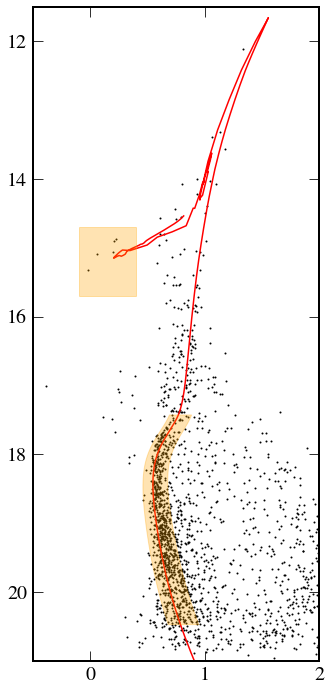

In [19]:
plt.figure(figsize=(5,10))
plt.plot(t['bp_rp0'][ind_phi2 & ind_pm], t['g0'][ind_phi2 & ind_pm], 'ko', ms=2, mew=0, alpha=1)
plt.plot(i_bprp, i_g, 'r-')

pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

pm = mpl.patches.Polygon(poly_bhb, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

# plt.gca().invert_yaxis()
plt.xlim(-0.5, 2)
plt.ylim(21, 11.5)
plt.tight_layout()

## eq selection

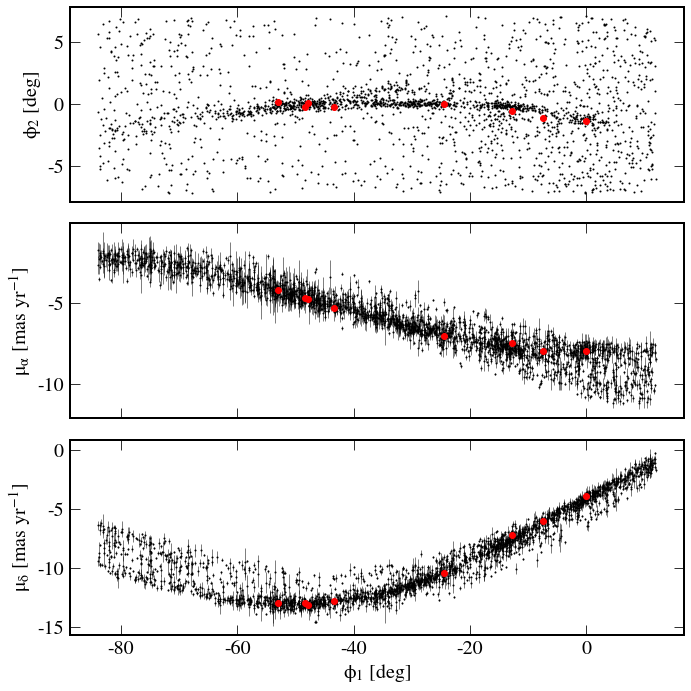

In [32]:
y = [c.phi2.value, t['pmra'], t['pmdec']]
yerr = [(t['dec_error']*u.mas).to(u.deg).value, t['pmra_error'], t['pmdec_error']]
nr = len(y)

ylabels = ['$\phi_2$ [deg]', '$\mu_{\\alpha}$ [mas yr$^{-1}$]', '$\mu_{\delta}$ [mas yr$^{-1}$]']

ind_mem = ind_pm & ind_cmd
ind_mem_bhb = ind_pm & ind_bhb & (c.phi2<0.5*u.deg) & (c.phi2>-2.5*u.deg)

fig, ax = plt.subplots(nr, 1, figsize=(10,10), sharex=True)

for i in range(nr):
    plt.sca(ax[i])
    plt.errorbar(c.phi1.value[ind_mem], y[i][ind_mem], yerr=yerr[i][ind_mem], fmt='o', ms=1, color='k', lw=0.5)
    plt.errorbar(c.phi1.value[ind_mem_bhb], y[i][ind_mem_bhb], yerr=yerr[i][ind_mem_bhb], fmt='o', color='r')
    plt.ylabel(ylabels[i])

plt.xlabel('$\phi_1$ [deg]')
    
plt.tight_layout()
# plt.savefig('../plots/gd1_track.png')

### Define stream track

In [33]:
Nbin = 50
cen_phi1 = np.linspace(-70,0,Nbin)*u.deg
med_phi2 = np.zeros(Nbin)*u.deg
w_phi1 = 4*u.deg
phi2_min = -5*u.deg
phi2_max = 4*u.deg

for i in range(Nbin):
    ind_ = (np.abs(c.phi1 - cen_phi1[i])<w_phi1) & (c.phi2>phi2_min) & (c.phi2<phi2_max)
    med_phi2[i] = np.median(c.phi2[ind_mem & ind_])

In [34]:
k_track = 2
p_track = np.polyfit(cen_phi1.value, med_phi2.value, k_track)
poly_track = np.poly1d(p_track)

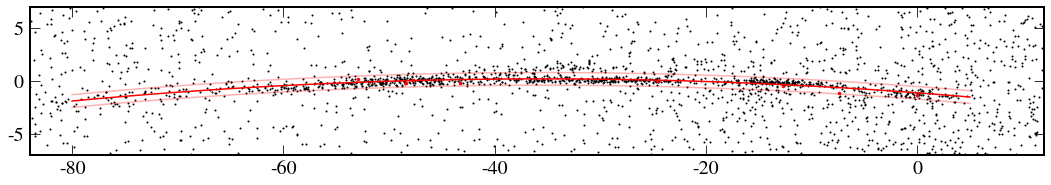

In [37]:
plt.figure(figsize=(15,7))
plt.plot(c.phi1[ind_mem], c.phi2[ind_mem], 'k.', ms=2)
plt.plot(c.phi1[ind_mem_bhb], c.phi2[ind_mem_bhb], 'r.', ms=5)
# plt.plot(cen_phi1, med_phi2, 'r-')

phi1_ = np.linspace(-80,5,100)
phi2_ = poly_track(phi1_)
plt.plot(phi1_, phi2_, 'r-')
plt.plot(phi1_, phi2_+0.6, 'r-', alpha=0.3)
plt.plot(phi1_, phi2_-0.6, 'r-', alpha=0.3)

plt.xlim(-84,12)
plt.ylim(-7,7)
plt.gca().set_aspect('equal')
plt.tight_layout()

In [38]:
width = 0.6*u.deg
ind_track = (np.abs(poly_track(c.phi1.value) - c.phi2.value)<width.value)

### Equatorial pm selection

[ 0.36379839  2.97088967 -6.59838666]


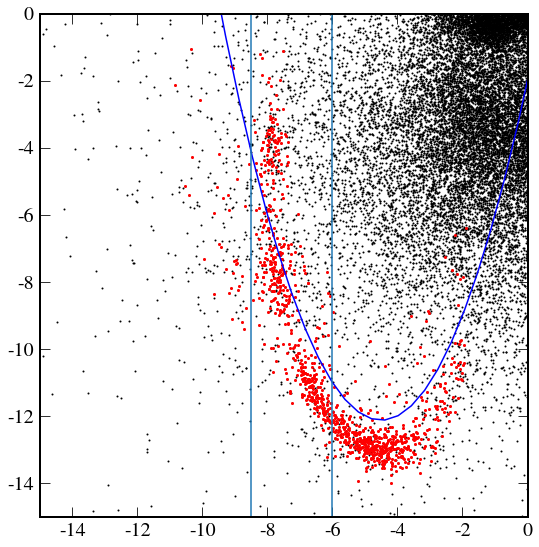

In [42]:
plt.plot(ceq_nc.pm_ra_cosdec[ind_cmd & ind_track], ceq_nc.pm_dec[ind_cmd & ind_track], 'k.', ms=2, alpha=1)
plt.plot(ceq_nc.pm_ra_cosdec[ind_cmd & ind_track & ind_pm], ceq_nc.pm_dec[ind_cmd & ind_track & ind_pm], 
         'ro', ms=2, alpha=1)

k_eq = 2
p_eq = np.polyfit(ceq_nc.pm_ra_cosdec[ind_cmd & ind_track & ind_pm].value, 
                  ceq_nc.pm_dec[ind_cmd & ind_track & ind_pm].value, k_eq)
print(p_eq)
p_eq = [0.5, 4.5, -2]
poly_eq = np.poly1d(p_eq)

pmra_ = np.linspace(-15, 5, 50)
pmdec_ = poly_eq(pmra_)
plt.plot(pmra_, pmdec_, 'b-')

plt.axvline(-6)
plt.axvline(-8.5)

plt.xlim(-15,0)
plt.ylim(-15,0)
plt.tight_layout()

In [40]:
ind_eq = (((ceq_nc.pm_ra_cosdec>-8.5*u.mas/u.yr) & (ceq_nc.pm_ra_cosdec<-6*u.mas/u.yr)) |
          ((ceq_nc.pm_ra_cosdec>-6*u.mas/u.yr) & (ceq_nc.pm_dec.value<poly_eq(ceq_nc.pm_ra_cosdec.value))))

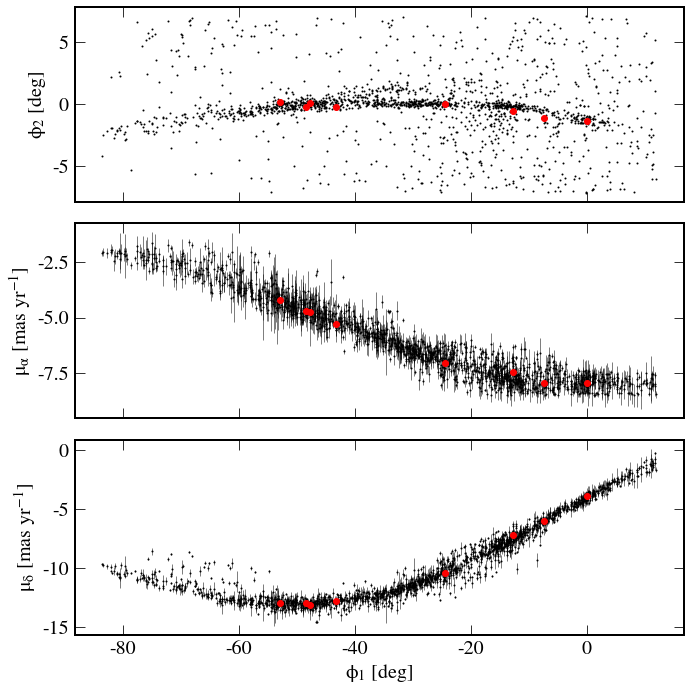

In [41]:
y = [c.phi2.value, t['pmra'], t['pmdec']]
yerr = [(t['dec_error']*u.mas).to(u.deg).value, t['pmra_error'], t['pmdec_error']]
nr = len(y)

ylabels = ['$\phi_2$ [deg]', '$\mu_{\\alpha}$ [mas yr$^{-1}$]', '$\mu_{\delta}$ [mas yr$^{-1}$]']

ind_mem = ind_pm & ind_eq & ind_cmd
ind_mem_bhb = ind_pm & ind_eq & ind_bhb & (c.phi2<0.5*u.deg) & (c.phi2>-2.5*u.deg)

fig, ax = plt.subplots(nr, 1, figsize=(10,10), sharex=True)

for i in range(nr):
    plt.sca(ax[i])
    plt.errorbar(c.phi1.value[ind_mem], y[i][ind_mem], yerr=yerr[i][ind_mem], fmt='o', ms=1, color='k', lw=0.5)
    plt.errorbar(c.phi1.value[ind_mem_bhb], y[i][ind_mem_bhb], yerr=yerr[i][ind_mem_bhb], fmt='o', color='r')
    plt.ylabel(ylabels[i])

plt.xlabel('$\phi_1$ [deg]')
    
plt.tight_layout()
# plt.savefig('../plots/gd1_track.png')

In [43]:
ind_mem = ind_pm & ind_eq & ind_cmd
ind_mem_bhb = ind_pm & ind_eq & ind_bhb & (c.phi2<0.5*u.deg) & (c.phi2>-2.5*u.deg)

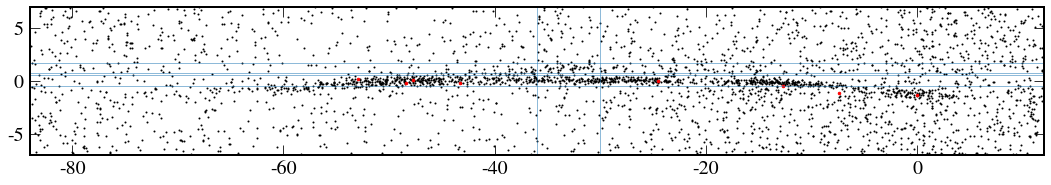

In [60]:
plt.figure(figsize=(15,7))
plt.plot(c.phi1[ind_mem], c.phi2[ind_mem], 'k.', ms=2)
plt.plot(c.phi1[ind_mem_bhb], c.phi2[ind_mem_bhb], 'r.', ms=5)
# plt.plot(cen_phi1, med_phi2, 'r-')

phi1_ = np.linspace(-80,5,100)
# phi2_ = poly_track(phi1_)
# plt.plot(phi1_, phi2_, 'r-')
# plt.plot(phi1_, phi2_+0.6, 'r-', alpha=0.3)
# plt.plot(phi1_, phi2_-0.6, 'r-', alpha=0.3)

lw = 0.5
plt.axvline(-36, lw=lw)
plt.axvline(-30, lw=lw)
plt.axhline(-0.5, lw=lw)
plt.axhline(0.5, lw=lw)
plt.axhline(0.7, lw=lw)
plt.axhline(1.7, lw=lw)

plt.xlim(-84,12)
plt.ylim(-7,7)
plt.gca().set_aspect('equal')
plt.tight_layout()

In [61]:
ind_spur = (c.phi1>-36*u.deg) & (c.phi1<-30*u.deg) & (c.phi2>0.7*u.deg) & (c.phi2<1.7*u.deg)
ind_stream = (c.phi1>-36*u.deg) & (c.phi1<-30*u.deg) & (c.phi2>-0.5*u.deg) & (c.phi2<0.5*u.deg)

ind_pmrec = ((c.pm_phi1_cosphi2>-8.2*u.mas/u.yr) & (c.pm_phi1_cosphi2<-4.2*u.mas/u.yr) & (c.pm_phi2>-1*u.mas/u.yr)
          & (c.pm_phi2<1*u.mas/u.yr))

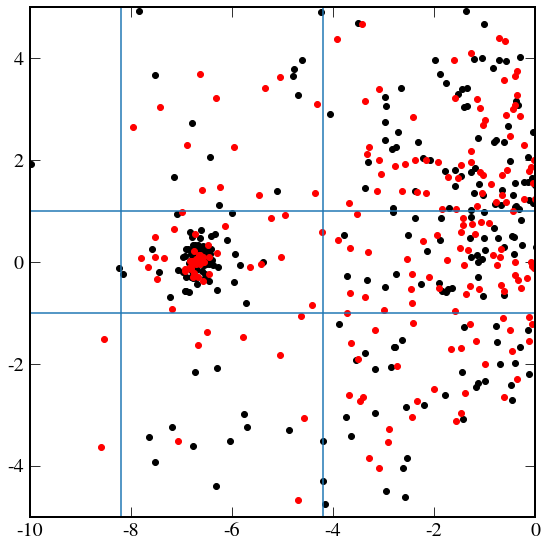

In [62]:
plt.plot(c.pm_phi1_cosphi2[ind_stream & ind_cmd], c.pm_phi2[ind_stream & ind_cmd], 'ko')
plt.plot(c.pm_phi1_cosphi2[ind_spur & ind_cmd], c.pm_phi2[ind_spur & ind_cmd], 'ro')

# plt.plot(poly_pm[:,0], poly_pm[:,1], 'b-')
plt.axvline(-8.2)
plt.axvline(-4.2)
plt.axhline(-1)
plt.axhline(1)

# plt.ylim(-1.5,1.5)
# plt.xlim(-8.5,-5)
plt.ylim(-5,5)
plt.xlim(-10,0)
plt.tight_layout()

In [63]:
print(np.median(c.pm_phi2.value[ind_stream & ind_cmd & ind_pmrec]),
      np.median(c.pm_phi2.value[ind_spur & ind_cmd & ind_pmrec]))
print(np.median(c.pm_phi1_cosphi2.value[ind_stream & ind_cmd & ind_pmrec]),
      np.median(c.pm_phi1_cosphi2.value[ind_spur & ind_cmd & ind_pmrec]))

0.039738514050004975 0.031020386048264292
-6.690774437217004 -6.7161604437368085


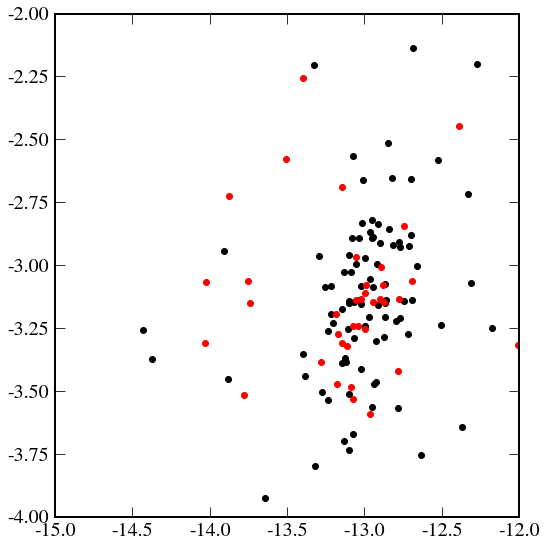

In [64]:
plt.plot(c_nc.pm_phi1_cosphi2[ind_stream & ind_cmd], c_nc.pm_phi2[ind_stream & ind_cmd], 'ko')
plt.plot(c_nc.pm_phi1_cosphi2[ind_spur & ind_cmd], c_nc.pm_phi2[ind_spur & ind_cmd], 'ro')

plt.ylim(-4,-2)
plt.xlim(-15,-12)
plt.tight_layout()

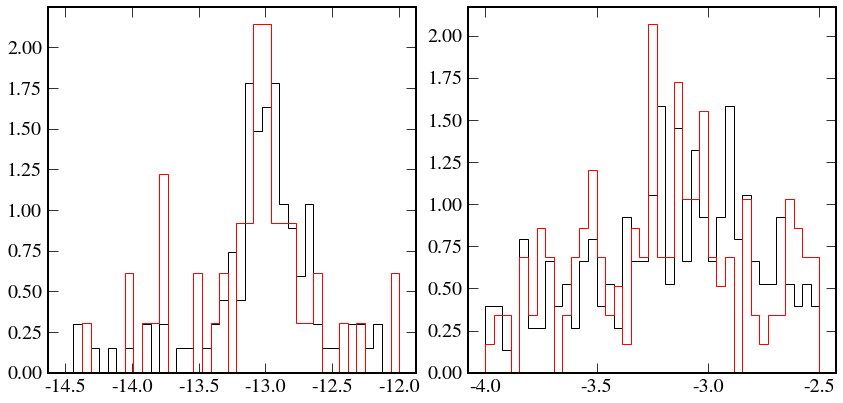

In [65]:
bins_pm1 = np.linspace(-14.5,-12,40)
bins_pm2 = np.linspace(-4,-2.5,40)

fig, ax = plt.subplots(1,2,figsize=(12,6))

plt.sca(ax[0])
plt.hist(c_nc.pm_phi1_cosphi2.value[ind_stream & ind_cmd], bins=bins_pm1,
         histtype='step', density=True, color='k')
plt.hist(c_nc.pm_phi1_cosphi2.value[ind_spur & ind_cmd], bins=bins_pm1,
         histtype='step', density=True, color='r')

plt.sca(ax[1])
plt.hist(c_nc.pm_phi2.value[ind_stream & ind_cmd], bins=bins_pm2,
         histtype='step', density=True, color='k')
plt.hist(c_nc.pm_phi2.value[ind_spur & ind_cmd], bins=bins_pm2,
         histtype='step', density=True, color='r')

plt.tight_layout()

In [66]:
print(np.median(c_nc.pm_phi2.value[ind_stream & ind_cmd & ind_pmrec]),
      np.median(c_nc.pm_phi2.value[ind_spur & ind_cmd & ind_pmrec]))
print(np.median(c_nc.pm_phi1_cosphi2.value[ind_stream & ind_cmd & ind_pmrec]),
      np.median(c_nc.pm_phi1_cosphi2.value[ind_spur & ind_cmd & ind_pmrec]))

-3.1462088803705717 -3.142816644175217
-12.965949678577042 -13.031686799021044


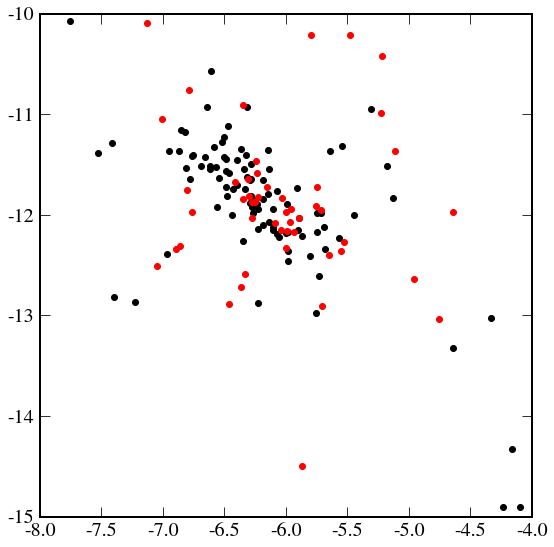

In [67]:
plt.plot(ceq_nc.pm_ra_cosdec[ind_stream & ind_cmd], ceq_nc.pm_dec[ind_stream & ind_cmd], 'ko')
plt.plot(ceq_nc.pm_ra_cosdec[ind_spur & ind_cmd], ceq_nc.pm_dec[ind_spur & ind_cmd], 'ro')

plt.ylim(-15,-10)
plt.xlim(-8, -4)
plt.tight_layout()

### Bootstrap errors

In [68]:
ind_mem = ind_cmd & ind_pmrec #ind_pm & ind_eq
Nstar = np.sum(ind_mem)

ind_mem_spur = ((c.phi1[ind_mem]>-36*u.deg) & (c.phi1[ind_mem]<-30*u.deg) & 
                (c.phi2[ind_mem]>0.7*u.deg) & (c.phi2[ind_mem]<1.7*u.deg))
ind_mem_stream = ((c.phi1[ind_mem]>-36*u.deg) & (c.phi1[ind_mem]<-30*u.deg) & 
                  (c.phi2[ind_mem]>-0.5*u.deg) & (c.phi2[ind_mem]<0.5*u.deg))


Nboot = 500
pm_phi1 = np.empty((2, Nboot))
pm_phi2 = np.empty((2, Nboot))
pm_phi1_nc = np.empty((2, Nboot))
pm_phi2_nc = np.empty((2, Nboot))

np.random.seed(529)

for i in range(Nboot):
    pmra = t['pmra'][ind_mem]*u.mas/u.yr + np.random.randn(Nstar) * t['pmra_error'][ind_mem]*u.mas/u.yr
    pmdec = t['pmdec'][ind_mem]*u.mas/u.yr + np.random.randn(Nstar) * t['pmdec_error'][ind_mem]*u.mas/u.yr
    ceq_nc_boot = coord.SkyCoord(ra=t['ra'][ind_mem]*u.deg, dec=t['dec'][ind_mem]*u.deg, distance=arr_dist[ind_mem],
                      pm_ra_cosdec=pmra, pm_dec=pmdec,
                      radial_velocity=np.zeros(Nstar)*u.km/u.s, frame='icrs')
    c_nc_boot = ceq_nc_boot.transform_to(gc.GD1)

    ceq_boot = gc.reflex_correct(ceq_nc_boot)
    c_boot = ceq_boot.transform_to(gc.GD1)
    
    pm_phi1[0][i] = np.median(c_boot.pm_phi1_cosphi2.value[ind_mem_stream])
    pm_phi1[1][i] = np.median(c_boot.pm_phi1_cosphi2.value[ind_mem_spur])
    pm_phi2[0][i] = np.median(c_boot.pm_phi2.value[ind_mem_stream])
    pm_phi2[1][i] = np.median(c_boot.pm_phi2.value[ind_mem_spur])
    
    pm_phi1_nc[0][i] = np.median(c_nc_boot.pm_phi1_cosphi2.value[ind_mem_stream])
    pm_phi1_nc[1][i] = np.median(c_nc_boot.pm_phi1_cosphi2.value[ind_mem_spur])
    pm_phi2_nc[0][i] = np.median(c_nc_boot.pm_phi2.value[ind_mem_stream])
    pm_phi2_nc[1][i] = np.median(c_nc_boot.pm_phi2.value[ind_mem_spur])

In [69]:
arrays = [pm_phi1, pm_phi2, pm_phi1_nc, pm_phi2_nc]
labels = ['pm phi1', 'pm phi2', 'pm phi1 nc', 'pm phi2 nc']

for i in range(4):
    med = np.median(arrays[i], axis=1)
    std = np.std(arrays[i], axis=1)
    delta = med[0] - med[1]
    err = np.sqrt(np.sum(std**2))
    print('{:s} {:.4f} {:.4f}'.format(labels[i], delta, err))

pm phi1 0.0205 0.0569
pm phi2 0.0117 0.0555
pm phi1 nc 0.0289 0.0594
pm phi2 nc 0.0040 0.0576


## Density profile

In [110]:
dwide = 4 * u.deg
hwide = 0.5 * dwide
dfine = 0.3
xmin = -80
xmax = 10
xbins = np.arange(xmin, xmax+dfine, dfine)*u.deg
Nbin = np.size(xbins)
rho = np.zeros(Nbin)
rho_basic = np.zeros(Nbin)

for i in range(Nbin):
    ind_ = ind_pm & ind_eq & ind_cmd & ind_track & (c.phi1>=xbins[i]-hwide) & (c.phi1<xbins[i]+hwide)
    rho[i] = np.sum(ind_)
    ind_ = ind_pmrec & ind_cmd & ind_track & (c.phi1>=xbins[i]-hwide) & (c.phi1<xbins[i]+hwide)
    rho_basic[i] = np.sum(ind_)

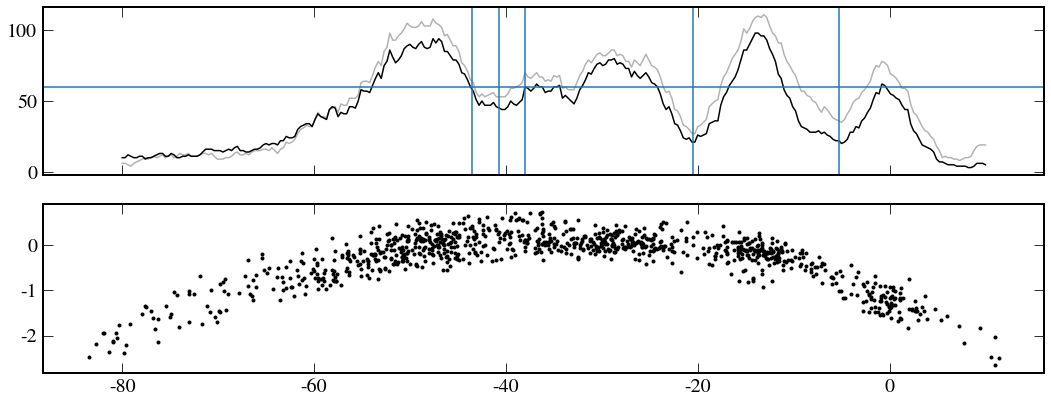

In [122]:
fig, ax = plt.subplots(2,1,figsize=(15,6), sharex=True)

plt.sca(ax[0])
plt.plot(xbins, rho, 'k-')
plt.plot(xbins, rho_basic, 'k-', alpha=0.3)
for xdip in [-5.3, -20.5, -40.75]:
    plt.axvline(xdip)
plt.axhline(60)
plt.axvline(-38)
plt.axvline(-43.5)

plt.sca(ax[1])
plt.plot(c.phi1[ind_mem], c.phi2[ind_mem], 'k.')

plt.tight_layout()

In [128]:
print(p_track, pdist)

[-1.05312230e-03 -7.45531149e-02 -1.14641496e+00] [-2.92041948e-05 -1.27280865e-03  5.93256672e-02  9.61721443e+00]


In [129]:
# track
pb_phi2 = np.array([-1.05312230e-03, -7.45531149e-02, -1.14641496e+00])
get_phi2 = np.poly1d(pb_phi2)

In [130]:
# distance
pb_distance = np.array([-2.92041948e-05, -1.27280865e-03, 5.93256672e-02, 9.61721443e+00])
get_distance = np.poly1d(pb_distance)